In [1]:
import pandas as pd
import numpy as np
import auxiliary_functions as aux
from sklearn.model_selection import StratifiedKFold

cepi = pd.read_csv('C Elegans dataset examples\Version-1 datasets (no score threshold)\CElegans Protein Interactors dataset_v1.tsv', sep='\t')
dmpi = pd.read_csv('Drosophila datasets (validation experiment)/Drosophila Protein Interactors .tsv', sep='\t')
cego = pd.read_csv('C Elegans dataset examples\Version-1 datasets (no score threshold)\CElegans GOTerms dataset_v1.tsv', sep='\t')
dmgo = pd.read_csv('Drosophila datasets (validation experiment)\Drosophila GO Terms.tsv', sep='\t')

In [2]:
drop_cols = [
    'Instance_Index',
    'STITCH_Code',
    'STITCH_Compound',
    'STITCH Code',
    'InteractorsList',
    'InteractorsCount'
]
cepi.drop(columns=drop_cols, errors='ignore',inplace=True)
dmpi.drop(columns=drop_cols, errors='ignore',inplace=True)
cego.drop(columns=drop_cols, errors='ignore',inplace=True)
dmgo.drop(columns=drop_cols, errors='ignore',inplace=True)

(cepi.shape, dmpi.shape, cego.shape, dmgo.shape)

((1120, 5789), (45, 5789), (1120, 9001), (45, 9001))

In [3]:
unusable_feature_threshold = 10

cepi_tmp, dmpi_tmp = aux.removeLowFrequencyFeatures_TrainTest(cepi, dmpi, unusable_feature_threshold)
cego_tmp, dmgo_tmp = aux.removeLowFrequencyFeatures_TrainTest(cego, dmgo, unusable_feature_threshold)

(cepi_tmp.shape, dmpi_tmp.shape, cego_tmp.shape, dmgo_tmp.shape)

((1120, 5789), (45, 5789), (1120, 7707), (45, 7707))

In [4]:
dmpi_tmp = aux.removeLowFrequencyFeatures(dmpi, 1)
dmgo_tmp = aux.removeLowFrequencyFeatures(dmgo, 1)

dmpi_tmp.shape, dmgo_tmp.shape


((45, 4305), (45, 6835))

In [37]:
def markFeatureAsLowFrequency(training_set, threshold):
    features = []
    if threshold > 0:
        number_instances = training_set.shape[0]
        for feature in training_set:
            try:
                mostFrequent = training_set[feature].value_counts(ascending=True)[0]
            except:
                mostFrequent = 0
            if number_instances - mostFrequent < threshold:
                features.append(feature)
    return features
def getFilteredFeatures(df, unusable_feature_threshold):
    kf = StratifiedKFold(n_splits=10, shuffle=False)
    fold = 0
    allFoldFeatures = []
    for train_index, test_index in kf.split(df.iloc[:, :-1], df.iloc[:, -1]):
        fold = fold + 1
        training_set = df.iloc[train_index, :]
        lowFrequency = markFeatureAsLowFrequency(training_set, unusable_feature_threshold)
        for low in lowFrequency:
            if not (low in allFoldFeatures):
                allFoldFeatures.append(low)
        
        print(f'{fold-1}, {len(lowFrequency)}, {len(allFoldFeatures)}')
    return allFoldFeatures

def kl_divergence(p, q):
    val = []
    for i in range(len(p)):
        # if p[i]==0:
        #     val.append(0)
        if q[i] == 0:
            return np.nan
        else: 
            val.append(np.log2((p[i]/q[i])**p[i]))
    return sum(val)

def get_probability_distribution(col_p, col_q):
    n_col_p = col_p.shape[0]
    n_col_q = col_q.shape[0]
    p = col_p.value_counts().reindex([0,1], fill_value=0).values/n_col_p
    q = col_q.value_counts().reindex([0,1], fill_value=0).values/n_col_q
    return p,q

def kl(col_p, col_q):
    p,q = get_probability_distribution(col_p, col_q)
    return kl_divergence(p,q)

def js(col_p, col_q):
    p,q = get_probability_distribution(col_p, col_q)
    m = (p+q)/2
    return (kl_divergence(p,m)+kl_divergence(q,m))/2

def summarize(df1, df2, unusable_feature_threshold=10):
    result = {
        'feature': [],
        'proportion_true_n_ce': [], 
        'proportion_true_n_dm': [],
        'drop': [],
        'drop_in_some_fold': [],
        'kl': [],
        'js':[]
    }
    df1_n = df1.shape[0]
    df2_n = df2.shape[0]
    
    drop_in_some_fold = getFilteredFeatures(df2, unusable_feature_threshold=unusable_feature_threshold)
    
    for feature in df2.columns:
        true_ce = df2[feature].sum()
        true_dm = df1[feature].sum()
        result['feature'].append(feature)
        result['proportion_true_n_ce'].append(true_ce/df2_n)
        result['proportion_true_n_dm'].append(true_dm/df1_n)
        result['drop'].append(true_ce < unusable_feature_threshold)
        result['drop_in_some_fold'].append(feature in drop_in_some_fold)
        result['kl'].append(kl(df1[feature], df2[feature]))
        result['js'].append(js(df1[feature], df2[feature]))
    return result

In [38]:
pi = pd.DataFrame(summarize(dmpi, cepi))
go = pd.DataFrame(summarize(dmgo, cego))


0, 486, 486
1, 227, 535
2, 271, 658
3, 231, 699
4, 111, 703
5, 182, 715
6, 218, 730
7, 257, 751
8, 369, 791
9, 196, 799
0, 1296, 1296
1, 1306, 1308
2, 1333, 1342
3, 1325, 1367
4, 1357, 1400
5, 1345, 1412
6, 1381, 1442
7, 1414, 1486
8, 1484, 1549
9, 1884, 1913


In [41]:
with pd.ExcelWriter('measuring_ds.xlsx') as writer:  
    pi.to_excel(writer, sheet_name='Protein interactors')
    go.to_excel(writer, sheet_name='Gene ontology')

<Axes: ylabel='Frequency'>

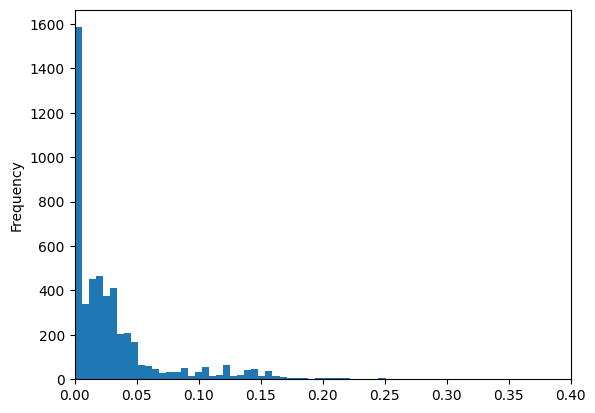

In [42]:
pi[pi.drop_in_some_fold == False].kl.plot.hist(bins=50, xlim=(0,0.4))

<Axes: ylabel='Frequency'>

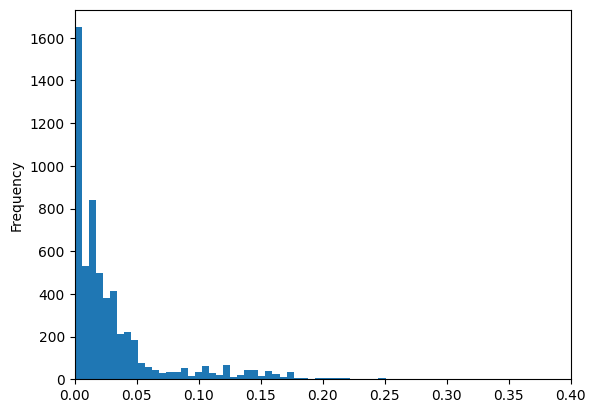

In [43]:
pi.kl.plot.hist(bins=50, xlim=(0,0.4))

<Axes: ylabel='Frequency'>

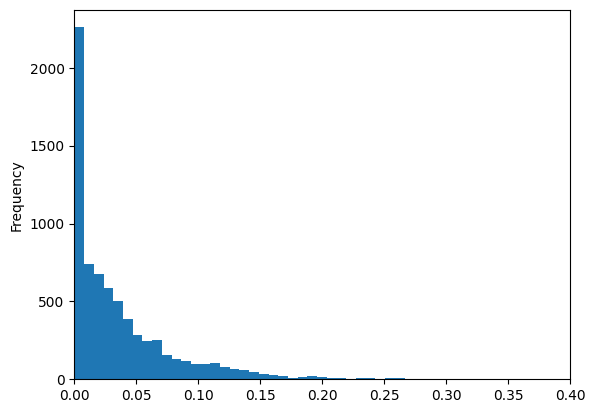

In [44]:
go[go.drop_in_some_fold == False].kl.plot.hist(bins=50, xlim=(0,0.4))

<Axes: ylabel='Frequency'>

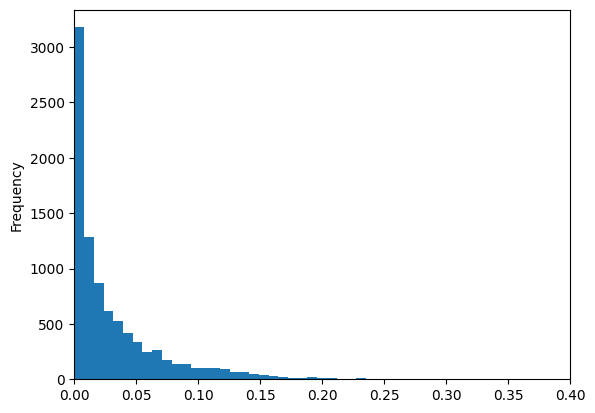

In [11]:
go.kl.plot.hist(bins=50, xlim=(0,0.4))